# Modeling the Spread of Misinformation in Social Networks using Graph Theory.



## Introduction
In the age of digital communication, social media serves as the main platform for the exchange of information. However, as social media platforms have matured and become more popular, they have created new breeding grounds for the spread of harmful misinformation and disinformation campaigns. This notebook aims to model the spread of misinformation in social networks (e.g., Twitter, Facebook, Reddit, etc.) using graph theory. By representing social networks as graphs, it is possible to simulate and analyze how misinformation propagates through these networks, identify key nodes (influencers, bad actors, etc.), and identify possible strategies to mitigate the spread of misinformation and reduce the impact of disinformation campaigns.

### Initial Setup
Import the necessary libraries and set up the environment for graph modeling and analysis.

In [2]:
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from IPython.display import display
from IPython.core.display_functions import clear_output

### Example Graph

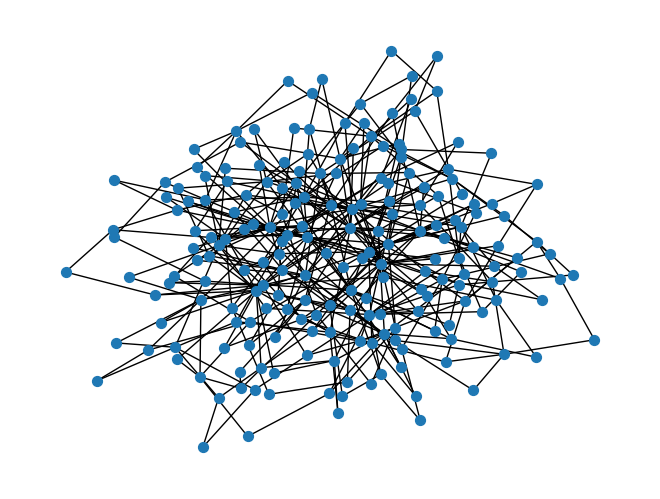

In [13]:
G = nx.barabasi_albert_graph(200, 2)
nx.draw(G, node_size=50)

As you can see, the graph represents a fairly basic social network where every node (person) is connected with a few other nodes (friends). The Barabási-Albert model is used because it has *Preferential attachment* and seems to accurately represent the formation of *hubs* (influential persons/platforms) in real-world social networks. [REFERENCE NEEDED]

In [158]:

# Define the types of information and virality of each information type
information_db = {
    'POLITICAL_MISINFO': {'type': 'misinformation', 'virality': 0.15},
    'SCIENTIFIC_MISINFO': {'type': 'misinformation', 'virality': 0.05},
    'POLITICAL_TRUTH': {'type': 'truth', 'virality': 0.10},
    'SCIENTIFIC_TRUTH': {'type': 'truth', 'virality': 0.04}
}

# Define node states
node_roles = {
    'NORMAL': {
        'convincing_power': 0.10,
        'shape': 'o',
        'base_size': 50,
    },
    'INFLUENCER': {
        'convincing_power': 0.25,
        'shape': 'o',
        'base_size': 75,
    },
    'GOOD_ACTOR': {
        'convincing_power': 0.20,
        'shape': '^',
        'base_size': 100,
    },
    'BAD_ACTOR': {
        'convincing_power': 0.20,
        'shape': 'v',
        'base_size': 100,
    }
}


# Define the colors for each node state for easier visualization.
color_map = {
    'NORMAL': 'gray',
    'SUSCEPTIBLE': 'gray',
    'INFLUENCER': 'yellow',
    'BAD_ACTOR': 'red',
    'GOOD_ACTOR': 'green',
}
N = 100 # number of nodes
M = 3 # minimum degree of each node
seed = random.randint(0, 100)
# Initialize the graph with the nodes and edges
G = nx.barabasi_albert_graph(n=N, m=M, seed=seed)

def simulate_step(graph, roles_dict):
    # We collect nodes to update *after* looping
    # This prevents a node from being infected and spreading in the same step
    nodes_to_update = {} # Stores {node_to_infect: new_belief}

    for node in graph.nodes():
        current_belief = graph.nodes[node]['belief']

        # 1. Check if this node is a spreader
        # (We will add IMMUNE later, so we check for specific beliefs)
        if current_belief == 'MISINFORMATION' or current_belief == 'TRUTH':

            # 2. Get the spreader's convincing power from their role
            role = graph.nodes[node]['role']
            power = roles_dict[role]['convincing_power']

            # 3. Find susceptible neighbors
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['belief'] == 'SUSCEPTIBLE':

                    # 4. Roll the dice
                    if random.random() < power:
                        # If successful, mark the neighbor for an update
                        # We only update if they haven't been marked by another belief
                        if neighbor not in nodes_to_update:
                            nodes_to_update[neighbor] = current_belief

    # 5. Apply all updates at once
    for node, new_belief in nodes_to_update.items():
        # Only update if they are still susceptible (first-come, first-served)
        if graph.nodes[node]['belief'] == 'SUSCEPTIBLE':
            graph.nodes[node]['belief'] = new_belief

    return graph # Return the modified graph

# Set all node roles to 'NORMAL'
for node in G.nodes():
    G.nodes[node]['role'] = 'NORMAL'
    G.nodes[node]['belief'] = 'SUSCEPTIBLE'

# Find and set influencer nodes based on their degree
popularity_condition = lambda x: x > 30
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
for node in degrees:
    if popularity_condition(node[1]):
        G.nodes[node[0]]['role'] = 'INFLUENCER'

# Randomly assign some GOOD_ACTOR and BAD_ACTOR nodes
GOOD_ACTORS_CAP = 2
BAD_ACTORS_CAP = 2
normal_nodes = [node for node in G.nodes() if G.nodes[node]['role'] == 'NORMAL']
random.shuffle(normal_nodes)

for i in range(GOOD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'TRUTH'

for i in range(BAD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'BAD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'MISINFORMATION'

# Set shapes based on node roles
node_shapes = []
for node in G.nodes():
    role = G.nodes[node]['role']
    node_shapes.append(node_roles[role]['shape'])
print(node_shapes)

# Set sizes of nodes based on their roles
node_sizes = []
for node in G.nodes():
    role = G.nodes[node]['role']

    size = node_roles[role]['base_size']

    if role == 'INFLUENCER':
        size = size + (G.degree[node] * 10)

    node_sizes.append(size)

# Set colors based on node roles
node_colors = []
for node in G.nodes():
    role = G.nodes[node]['role']
    node_colors.append(color_map[role])

pos = nx.spring_layout(G, seed=seed)


history = []
simulation_steps = 100

print("STARTING SIMULATION...")

for step in range(simulation_steps):

    G = simulate_step(G, node_roles)

    counts = {
        'SUSCEPTIBLE': 0,
        'MISINFORMATION': 0,
        'TRUTH': 0,
    }

    for node in G.nodes():
        counts[G.nodes[node]['belief']] += 1
    history.append(counts)

    clear_output(wait=True)
    fig = plt.figure(figsize=(12, 8))

    # --- Subplot 1: Network Graph ---
    ax1 = plt.subplot(1, 2, 1)

    node_colors = [color_map.get(G.nodes[node]['belief'], '#999999') for node in G.nodes()]

    for role_name, attributes in node_roles.items():
        shape = attributes['shape']
        nodelist = [node for node in G.nodes() if G.nodes[node]['role'] == role_name]
        if not nodelist:
            continue

        indices = list(G.nodes())
        size_list = [node_sizes[indices.index(n)] for n in nodelist]
        color_list = [node_colors[indices.index(n)] for n in nodelist]

        nx.draw_networkx_nodes(G, pos,
                               ax=ax1,
                               nodelist=nodelist,
                               node_shape=shape,
                               node_color=color_list,
                               node_size=size_list)

    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.1)
    ax1.set_title("Simulation Spread")
    ax1.set_axis_off()

    # --- Subplot 2: Line Chart ---
    ax2 = plt.subplot(1, 2, 2)
    susceptible_history = [h['SUSCEPTIBLE'] for h in history]
    misinformation_history = [h['MISINFORMATION'] for h in history]
    truth_history = [h['TRUTH'] for h in history]

    ax2.plot(susceptible_history, label='Susceptible', color=color_map['SUSCEPTIBLE'], linestyle=':')
    ax2.plot(misinformation_history, label='Misinformation', color=color_map['BAD_ACTOR'], linewidth=2)
    ax2.plot(truth_history, label='Truth', color=color_map['GOOD_ACTOR'], linewidth=2)

    ax2.set_title("Spread Over Time")
    ax2.set_xlabel("Time (Steps)")
    ax2.set_ylabel("Number of People")
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, N)
    ax2.set_xlim(0, simulation_steps)

    plt.suptitle(f"Misinformation Simulation: Step {step + 1}/{simulation_steps}", fontsize=16)
    plt.show()
    time.sleep(0.1)



In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np

print("--- Starting Test Animation (Flicker + Close Method) ---")

# 2. Create the data
x = np.linspace(0, 10, 100)
y = np.sin(x + i / 5.0)

# 3. Create a brand-new figure and plot
# We'll grab the figure object 'fig'
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y)
ax.set_title(f"Frame {i}")

# 4. Display the plot
plt.show()

# 5. *** THE FIX ***
# Close the figure to free memory and prevent re-drawing
plt.close(fig)

# 6. Pause
time.sleep(0.1)

print("--- Test Complete ---")

--- Starting Test Animation (Flicker + Close Method) ---


<IPython.core.display.Javascript object>

--- Test Complete ---
